# Dynamic programming lab notebook

## Students involved :
- Paul PHILIPPE - 21112687: paul-etienne.philippe@etu.sorbonne-universite.fr
- William WU - 21107936: william.wu@etu.sorbonne-universite.fr

 Copyright © Sorbonne University.

 This source code is licensed under the MIT license found in the LICENSE file
 in the root directory of this source tree.

# Outlook

In this notebook, we study the **value iteration** and **policy
iteration** algorithms in a maze environment.

In [ ]:
%pip install -q swig==4.3.1


%pip install -q bbrl-utils==1.1.0
%pip install -q gymnasium[mujoco]==1.2.0
%pip install -q mazemdp==1.2.12


   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.9/1.9 MB 29.1 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 374.4/374.4 kB 25.7 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 42.0/42.0 kB 2.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 60.1/60.1 kB 4.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 154.5/154.5 kB 11.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 6.8/6.8 MB 91.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.8/1.8 MB 65.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 243.5/243.5 kB 17.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.6/1.6 MB 58.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 944.3/944.3 kB 18.0 MB/s eta 0:00:00


In [ ]:
try:
    # Allows to enable custom widgets
    from google.colab import output

    output.enable_custom_widget_manager()
except ModuleNotFoundError:
    pass

# Installation

In [ ]:
import bbrl_utils

from pathlib import Path
from typing import List, Tuple
from mazemdp import random_policy

import gymnasium as gym
import numpy as np
from bbrl_gymnasium.envs.maze_mdp import MazeMDPEnv
import matplotlib.pyplot as plt

bbrl_utils.setup()

Matplotlib backend: module://matplotlib_inline.backend_inline


# Agents and MDPs

A reinforcement learning agent interacts with an environment represented as a
Markov Decision Process (MDP). It is defined by a tuple $(S, A, P, r, \gamma)$
where $S$ is the state space, $A$ is the action space, $P(state_t, action_t,
state_{t+1})$ is the transition function, $r(state_t, action_t)$ is the reward
function and $\gamma \in [0, 1]$ is the discount factor.

In what follows we import code to create an MDP corresponding to a random maze
(see https://github.com/osigaud/SimpleMazeMDP for documentation).

In [ ]:
env = gym.make(
    "MazeMDP-v0",
    kwargs={"width": 5, "height": 5, "ratio": 0.2},
    render_mode="human",
)
env.reset()

# in dynamic programming, there is no agent moving in the environment
env.unwrapped.set_no_agent()
env.unwrapped.init_draw("The maze")

       [-1,  4,  9, 13, 17],
       [-1,  5, -1, …

Dynamic programming

The goal of an RL agent is to find the optimal behaviour, defined by a policy
$\pi$ that assigns an action (or distribution over actions) to each state so
as to maximize the agent's total expected reward. In order to estimate how
good a state is, either a state value function $V(x)$ or a state-action value
function $Q(s, a)$ is used.

Dynamic programming algorithms are used for planning, they require a full
knowledge of the MDP from the agent (in contrast to "true" RL where the agent
does not know the transition and reward functions). They find the optimal
policy by computing a value function $V$ or an action-value function $Q$ over
the state space or state-action space of the given MDP. **Value iteration**
and **policy iteration** are two standard dynamic programming algorithms. You
should study both of them using both $V$ and $Q$, as these algorithms contain
the basic building blocks for most RL algorithms.

# Value Iteration

## Value Iteration with the V function

When using the $V$ function, **value iteration** aims at finding the optimal
values $V^*$ based on the Bellman Optimality Equation: $$V^*(s) = \max_a
\big[r(s,a) + \gamma \sum_{y \in S} P(s,a,y)V^*(y) \big],$$ where:

*   $r(s, a)$ is the reward obtained from taking action $a$ in state $s$,
*   $P(s, a, y)$ is the probability of reaching state $y$ when taking action
    $a$ in state $s$,
*   $\gamma \in [0,1]$ is a discount factor defining the relative importance
    of long term rewards over short term ones (the closer to 0, the more the
    agent focuses on immediate rewards).

In practice, we start with an initial value function $V^0$ (for instance, the
values of all states are 0), and then we iterate for all states $s$
$$V^{i+1}(s) = \max_a \big[ r(s,a) + \gamma \sum_{y \in S} P(s,a,y)V^i(y)
\big],$$

until the values converge, that is $\forall s, V^{i+1}(s) \approx V^i(s)$. It
is shown that at convergence, $\forall s, V^i(s)= V^*(s)$.

To visualize the policy obtained from **value iteration**, we need to first
define the `get_policy_from_V()` function

In [ ]:
def get_policy_from_v(mdp: MazeMDPEnv, v: np.ndarray) -> np.ndarray:
    """Outputs a policy given the state values"""

    # Sets initial state values are set to 0
    policy = np.zeros(mdp.nb_states)

    # Loop over MDP states
    for s in range(mdp.nb_states):
        if s in mdp.terminal_states:
            # Takes the reward associated with the terminal state
            policy[s] = np.argmax(mdp.r[s, :])
        else:
            # Compute the value V(x) for state x
            v_temp = []

            # Loop over actions
            for a in range(mdp.action_space.n):
                # Process sum of the values of the neighbouring states
                summ = 0
                for y in range(mdp.nb_states):
                    summ = summ + mdp.P[s, a, y] * v[y]
                v_temp.append(mdp.r[s, a] + mdp.gamma * summ)
            policy[s] = np.argmax(v_temp)
    return policy

The `value_iteration_v(mdp)` function below provides the code of **value
iteration** using the $V$ function. It is given as an example from which you
can derive other instances of dynamic programming algorithms. Look at it more
closely, this will help for later questions:

* you can ignore the `mdp.new_render()` and `mdp.render(...)` functions which
  are here to provide the visualization of the iterations.
* find in the code the loop over states, the main loop that performs these
  updates until the values don't change significantly anymore, the main update
  equation. Found them? OK, you can continue...

In [ ]:
def value_iteration_v(
    mdp: MazeMDPEnv, render: bool = True
) -> Tuple[np.ndarray, List[float]]:
    # Value Iteration using the state value v
    v = np.zeros(mdp.nb_states)  # initial state values are set to 0
    v_list = []
    stop = False

    mdp.init_draw("Value iteration V")

    mdp.draw_v(v)

    while not stop:
        v_old = v.copy()
        mdp.draw_v(v)

        for s in range(mdp.nb_states):  # for each state x
            # Compute the value of the state x for each action u of the MDP action space
            if s in mdp.terminal_states:
                v[s] = np.max(mdp.r[s, :])
            else:
                v_temp = []
                for a in range(mdp.action_space.n):
                    # Process sum of the values of the neighbouring states
                    summ = 0
                    for y in range(mdp.nb_states):
                        summ = summ + mdp.P[s, a, y] * v_old[y]
                    v_temp.append(mdp.r[s, a] + mdp.gamma * summ)

                # Select the highest state value among those computed
                v[s] = np.max(v_temp)

        # Test if convergence has been reached
        if (np.linalg.norm(v - v_old)) < 0.01:
            stop = True
        v_list.append(np.linalg.norm(v))

    policy = get_policy_from_v(mdp, v)
    mdp.draw_v_pi(v, policy)
    return v, v_list

Let us run it on the previously defined MDP

In [ ]:
v, v_list = value_iteration_v(env.unwrapped, render=True)

       [-1,  4,  9, 13, 17],
       [-1,  5, -1, …

### Value iteration with the $Q$ function ###

The state-action value function $Q^{\pi}(s,a)$ defines the value of being in
state $s$, taking action $a$ then following policy $\pi$. The Bellman
Optimality Equation for $Q^*$ is $$ Q^*(s,a) =  r(s,a) + \gamma \sum_{y}
P(s,a,y) \max_{a'}Q^*(y,a'). $$

**Question:** By taking inspiration from the `value_iteration_v(mdp)` function
above, fill the blank (given with '\#Q[s, a]=...') in the code of
`value_iteration_q(mdp)`.

In [ ]:
# ------------------ Value Iteration with the Q function ---------------------#
# Given a MDP, this algorithm computes the optimal action value function Q
# It then derives the optimal policy based on this function


def value_iteration_q(
    mdp: MazeMDPEnv, render: bool = True
) -> Tuple[np.ndarray, List[float]]:
    q = np.zeros(
        (mdp.nb_states, mdp.action_space.n)
    )  # initial action values are set to 0
    q_list = []
    stop = False

    mdp.init_draw("Value iteration Q")

    mdp.draw_v(q)

    while not stop:
        qold = q.copy()

        mdp.draw_v(q)

        for s in range(mdp.nb_states):
            for a in range(mdp.action_space.n):
                if s in mdp.terminal_states:
                    q[s, a] = mdp.r[s, a]
                else:
                    summ = 0
                    for y in range(mdp.nb_states):
                        summ += mdp.P[s, a, y] * np.max(qold[y, :])

                    # Compléter d'après la formule ci-dessus

                    q[s, a] = mdp.r[s, a] + mdp.gamma * summ


        if (np.linalg.norm(q - qold)) <= 0.01:
            stop = True
        q_list.append(np.linalg.norm(q))

    mdp.draw_v(q)

    return q, q_list

Once you are done, run it.

In [ ]:
q, q_list = value_iteration_q(env.unwrapped, render=True)

       [-1,  4,  9, 13, 17],
       [-1,  5, -1, …

## Policy Iteration ##

The **policy iteration** algorithm is more complicated than **value
iteration**. Given a MDP and a policy $\pi$, **policy iteration** iterates the
following steps:

*   Evaluate policy $\pi$: compute $V$ or $Q$ based on the policy $\pi$;
*   Improve policy $\pi$: compute a better policy based on $V$ or $Q$.

This process is repeated until convergence, i.e. when the policy cannot be
improved anymore.

### Policy iteration with the $V$ function ###

When using $V$, $V^{\pi}(s)$ is the expected return when starting from state
$s$ and following policy $\pi$. It is processed based on the Bellman
Optimality Equation for deterministic policies:

$$V^\pi(s) = r(s, \pi(s)) + \gamma \sum_{y \in S}P(s, \pi(s), y)V^\pi(y),$$

where:

*   $\pi$ is a deterministic policy, meaning that in a state $s$, the agent
    always selects the same action,
*   $V^\pi(y)$ is the value of the state $y$ under policy $\pi$.

Thus, given a policy $\pi$, one must first compute its value function
$V^\pi(s)$ for all states $s$ iterating the Bellman Optimality Equation until
convergence, that is using **value iteration**. Then, one must determine if
policy $\pi$ can be improved based on $V$. For that, in each state $s$, one
can compute the Q-value $Q(s,a)$ of applying action $a$ and then following
policy $\pi$ based on the just computed $V^\pi$, and replace the action
$\pi(s)$ with $\arg\max_a Q(s,a)$.

In order to facilitate the coding of **policy iteration** algorithms, we first
define a set of useful functions.

The `improve_policy_from_v(mdp, v, policy)` function is very similar to the
`get_policy_from_v(v)` function which was given above. The main difference is
that it takes a policy as argument and improves this policy when possible,
thus is more in the spirit of the `policy improvement` step of **policy
iteration**. But both functions can be used interchangeably.

The functions `evaluate_one_step_v(mdp, v, policy)`, where `mdp` is a given
MDP, `v` is some value function in this MDP and `policy` is some policy and
the function `evaluate_v(mdp, policy)` are also given. These functions are
used to build the value function $V^\pi$ corresponding to policy $\pi$.

In [ ]:
def improve_policy_from_v(
    mdp: MazeMDPEnv, v: np.ndarray, policy: np.ndarray
) -> np.ndarray:
    # Improves a policy given the state values
    for s in range(mdp.nb_states):  # for each state x
        # Compute the value of the state x for each action u of the MDP action space
        if s in mdp.terminal_states:
            policy[s] = np.argmax(mdp.r[s, :])
        else:
            v_temp = np.zeros(mdp.action_space.n)
            for a in range(mdp.action_space.n):
                # Process sum of the values of the neighbouring states
                summ = 0
                for y in range(mdp.nb_states):
                    summ = summ + mdp.P[s, a, y] * v[y]
                v_temp[a] = mdp.r[s, a] + mdp.gamma * summ

            for a in range(mdp.action_space.n):
                if v_temp[a] > v_temp[policy[s]]:
                    policy[s] = a
    return policy

In [ ]:
def evaluate_one_step_v(
    mdp: MazeMDPEnv, v: np.ndarray, policy: np.ndarray
) -> np.ndarray:
    # Outputs the state value function after one step of policy evaluation
    # Corresponds to one application of the Bellman Operator
    v_new = np.zeros(mdp.nb_states)  # initial state values are set to 0
    for s in range(mdp.nb_states):  # for each state x
        # Compute the value of the state x for each action u of the MDP action space
        if s in mdp.terminal_states:
            v_new[s] = mdp.r[s, policy[s]]
        else:
            # Process sum of the values of the neighbouring states
            summ = 0
            for y in range(mdp.nb_states):
                summ = summ + mdp.P[s, policy[s], y] * v[y]
            v_new[s] = mdp.r[s, policy[s]] + mdp.gamma * summ
    return v_new

In [ ]:
def evaluate_v(mdp: MazeMDPEnv, policy: np.ndarray) -> np.ndarray:
    # Outputs the state value function of a policy
    v = np.zeros(mdp.nb_states)  # initial state values are set to 0
    stop = False
    while not stop:
        vold = v.copy()
        v = evaluate_one_step_v(mdp, vold, policy)

        # Test if convergence has been reached
        if (np.linalg.norm(v - vold)) < 0.01:
            stop = True
    return v

To perform **policy iteration** we also need an initial random policy.

**Question:** By using the above functions, fill the code of the `policy_iteration_v(mdp)` function below.

In [ ]:
# ---------------- Policy Iteration with the V function -----------------#
# Given an MDP, this algorithm simultaneously computes
# the optimal state value function V and the optimal policy


def policy_iteration_v(
    mdp: MazeMDPEnv, render: bool = True
) -> Tuple[np.ndarray, List[float]]:
    # policy iteration over the v function
    v = np.zeros(mdp.nb_states)  # initial state values are set to 0
    v_list = []
    policy = random_policy(mdp)

    stop = False

    mdp.init_draw("Policy Iteration (V)")

    while not stop:
        vold = v.copy()

        mdp.draw_v(v, title="Policy iteration Q")

        # Step 1 : Policy Evaluation
        # [[STUDENT]]...
        v = evaluate_v(mdp, policy)

        # Step 2 : Policy Improvement
        # [[STUDENT]]...
        policy = improve_policy_from_v(mdp, v, policy)

        # Check convergence
        if (np.linalg.norm(v - vold)) < 0.01:
            stop = True
        v_list.append(np.linalg.norm(v))

    mdp.draw_v_pi(v, get_policy_from_v(mdp, v))

    return v, v_list

And finally run it.

In [ ]:
v, v_list = policy_iteration_v(env.unwrapped, render=True)

       [-1,  4,  9, 13, 17],
       [-1,  5, -1, …

### Policy iteration with the $Q$ function ###

The **policy iteration** algorithm with the $Q$ function is the same as with
the $V$ function, but the policy improvement step is more straightforward.

When using $Q$, the Bellman Optimality Equation with deterministic policy
$\pi$ for $Q$ becomes: $$Q^{\pi}(s,a) = r(s,a) + \gamma \sum_{y \in
S}P(s,a,y)Q^{\pi}(y,\pi(y)).$$

The policy can then be updated as follows: $$\pi^{(t+1)}(s) =
\arg\max_aQ^{\pi^{(t)}}(s,a).$$

First, we need to determine a policy from the $Q$ function.

**Question:**  fill the `get_policy_from_q(q)` function, where $q$ is the
state-action value function.

In [ ]:
def get_policy_from_q(q: np.ndarray) -> np.ndarray:
    # Outputs a policy given the action values
    return np.argmax(q, axis=1)


**Question:** By drawing inspiration on the functions give with the $v$
function, fill the code of the `evaluate_one_step_q(mdp, q, policy)` function
below, where $q$ is some action value function, and the `evaluate_q(mdp,
policy)` function.

In [ ]:
def evaluate_one_step_q(
    mdp: MazeMDPEnv, q: np.ndarray, policy: np.ndarray
) -> np.ndarray:
    # Outputs the state value function after one step of policy evaluation
    qnew = np.zeros(
        (mdp.nb_states, mdp.action_space.n)
    )  # initial action values are set to 0
    for s in range(mdp.nb_states):  # for each state x
        # Compute the value of the state x for each action u of the MDP action space
        for a in range(mdp.action_space.n):
            if s in mdp.terminal_states:
                qnew[s, a] = mdp.r[s, a]
            else:
                # Process sum of the values of the neighbouring states
                summ = 0
                for y in range(mdp.nb_states):
                    # [[STUDENT]]...
                    summ += mdp.P[s, a, y] * q[y, policy[y]]

                # [[STUDENT]]...
                qnew[s, a] = mdp.r[s, a] + mdp.gamma * summ

    return qnew

In [ ]:
def evaluate_q(mdp: MazeMDPEnv, policy: np.ndarray) -> np.ndarray:
    # Outputs the state value function of a policy
    q = np.zeros(
        (mdp.nb_states, mdp.action_space.n)
    )  # initial action values are set to 0
    stop = False
    while not stop:
        qold = q.copy()

        # [[STUDENT]]...
        q = evaluate_one_step_q(mdp, qold, policy)

        # Test if convergence has been reached
        if (np.linalg.norm(q - qold)) < 0.01:
            stop = True
    return q

**Question:** By using the above functions, fill the code of the `policy_iteration_q(mdp)` function below.

In [ ]:
# ---------------- Policy Iteration with the Q function -----------------#
# Given a MDP, this algorithm simultaneously computes
# the optimal action value function Q and the optimal policy


def policy_iteration_q(
    mdp: MazeMDPEnv, render: bool = True
) -> Tuple[np.ndarray, List[float]]:
    """policy iteration over the q function."""
    q = np.zeros(
        (mdp.nb_states, mdp.action_space.n)
    )  # initial action values are set to 0
    q_list = []
    policy = random_policy(mdp)

    stop = False

    mdp.init_draw("Policy iteration Q")

    while not stop:
        qold = q.copy()
        mdp.draw_v(q)

        # Step 1 : Policy evaluation
        q = evaluate_q(mdp, policy)

        # Step 2 : Policy improvement
        policy = get_policy_from_q(q)

        # Check convergence
        if (np.linalg.norm(q - qold)) <= 0.01:
            stop = True
        q_list.append(np.linalg.norm(q))

    mdp.draw_v_pi(q, get_policy_from_q(q))
    return q, q_list

Finally, run it.

In [ ]:
q, q_list = policy_iteration_q(env.unwrapped, render=True)

       [-1,  4,  9, 13, 17],
       [-1,  5, -1, …

### Study part: Experimental comparisons

We will now compare the efficiency of the various dynamic programming methods using either the $V$ or the  $Q$ functions.

In all your dymanic programming functions, add code to count the number of iterations and the number of elementary $V$ or $Q$ updates. Use the provided `mazemdp.Chrono` class to measure the time taken. You may generate various mazes of various sizes to figure out the influence of the maze topology.

Build a table where you compare the various dymanic programming functions in terms of iterations, elementary operations and time taken.

You can run the `plot_convergence_vi_pi(...)` function provided below to visualize the convergence of the various algorithms.

In [ ]:
# ---- plot learning curves of Q-Learning and Sarsa using epsilon-greedy and softmax -----#


def plot_convergence_vi_pi(m, render):
    v, v_list1 = value_iteration_v(m, render)
    q, q_list1 = value_iteration_q(m, render)
    v, v_list2 = policy_iteration_v(m, render)
    q, q_list2 = policy_iteration_q(m, render)

    plt.plot(range(len(v_list1)), v_list1, label="value_iteration_v")
    plt.plot(range(len(q_list1)), q_list1, label="value_iteration_q")
    plt.plot(range(len(v_list2)), v_list2, label="policy_iteration_v")
    plt.plot(range(len(q_list2)), q_list2, label="policy_iteration_q")

    plt.xlabel("Number of episodes")
    plt.ylabel("Norm of V or Q value")
    plt.legend(loc="upper right")
    # plt.savefig("comparison_DP.png")
    plt.title("Comparison of convergence rates")
    plt.show()

**Question:** Run the code below and visualize the results of the different algorithms

       [-1,  4,  9, 13, 17],
       [-1,  5, -1, …

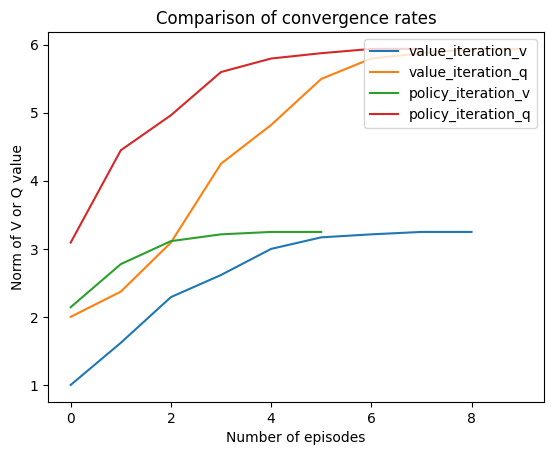

In [ ]:
plot_convergence_vi_pi(env.unwrapped, False)

Given the results above, discuss the relative computational efficiency of these methods.

Observations from the Experimental Results:

- Policy Iteration algorithms (V and Q) converge in fewer iterations (3-5) compared to Value Iteration methods (20-25).

- Value Iteration V shows slightly faster convergence than Value Iteration Q, both follow a similar monotonic pattern though.

- Policy Iteration V and Q demonstrate nearly identical convergence speeds in terms of iteration count, with Policy Iteration Q showing little initial oscillations.

Conclusions on Computational Efficiency:

- Policy Iteration is iteration-efficient: it requires around 4-6 times less iterations than Value Iteration, making it preferable when each iteration is computationally affordable.

- Value Iteration has cheaper iterations: each update is computationally simpler, potentially making it more suitable for very large state spaces despite requiring more iterations.

- V-based methods generally show smoother convergence curves compared to Q-based methods in both policy and value iteration approaches.

The choice between methods represents a trade-off: Policy Iteration minimizes iteration count while Value Iteration minimizes per-iteration computational cost. For moderate-sized problems like this maze, Policy Iteration appears more efficient overall.

# Study part: Generalized Policy Iteration

In this last part, we will code the **generalized policy iteration** algorithm and study the influence of the number of evaluation steps between each improvement step.
More precisely, we will consider an algorithm which starts from a policy, evaluates it **using only K iterations**, then computes the new policy corresponding to this value function, and so on until it converges.

The goal of the study is to find the value of K which leads to convergence in the smallest number of iterations, and to see how efficient it is with respect to using standard policy iteration (where each policy is evaluated until convergence of this evaluation). We will do this with the Q function and the V function.

## Generalized Policy Iteration with the Q function

In [ ]:
def evaluate_one_step_q_count(mdp: MazeMDPEnv, q: np.ndarray, policy: np.ndarray) -> np.ndarray:
    # Outputs the state value function after one step of policy evaluation
    # [[STUDENT]]...

    qnew = np.zeros((mdp.nb_states, mdp.action_space.n))

    for s in range(mdp.nb_states):
        for a in range(mdp.action_space.n):
            if s in mdp.terminal_states:
                qnew[s, a] = mdp.r[s, a]
            else:
                summ = 0
                for y in range(mdp.nb_states):
                    summ += mdp.P[s, a, y] * q[y, policy[y]]
                qnew[s, a] = mdp.r[s, a] + mdp.gamma * summ

    return qnew


A difference with respect to the standard policy iteration version is that now we pass the number of iterations K
K=-1 can be used to account for the case where we evaluate until convergence.

In [ ]:
def evaluate_q_K_steps(mdp: MazeMDPEnv, policy: np.ndarray, q: np.array, K: int) -> np.ndarray:
    # Outputs the state value function of a policy
    # [[STUDENT]]...

    if K == -1:
        return evaluate_q(mdp, policy)

    q_current = q.copy()
    for _ in range(K):
        q_current = evaluate_one_step_q_count(mdp, q_current, policy)
    return q_current


In [ ]:
def generalized_policy_iteration_q(mdp: MazeMDPEnv, render: bool = True, K: int = 1) -> Tuple[np.ndarray, List[float]]:
    """policy iteration over the q function."""
    # [[STUDENT]]...

    q = np.zeros((mdp.nb_states, mdp.action_space.n))
    q_list = []
    policy = random_policy(mdp)
    stop = False

    mdp.init_draw(f"Generalized Policy Iteration Q (K={K})")

    while not stop:
        qold = q.copy()
        # Policy evaluation with K steps
        q = evaluate_q_K_steps(mdp, policy, q, K)
        # Policy improvement then
        policy = get_policy_from_q(q)
        q_list.append(np.linalg.norm(q))

        if np.linalg.norm(q - qold) < 0.01:
            stop = True
        if render:
            mdp.draw_v(q)

    if render:
        mdp.draw_v_pi(q, policy)

    return q, q_list


In [ ]:
q, q_list = generalized_policy_iteration_q(env.unwrapped, render=True, K=1)

       [-1,  4,  9, 13, 17],
       [-1,  5, -1, …

## Generalized Policy Iteration with the V function

In [ ]:
def evaluate_one_step_v(mdp: MazeMDPEnv, v: np.ndarray, policy: np.ndarray) -> np.ndarray:
    # Outputs the state value function after one step of policy evaluation
    # Corresponds to one application of the Bellman Operator
    # [[STUDENT]]...
    v_new = np.zeros(mdp.nb_states)

    for s in range(mdp.nb_states):
        if s in mdp.terminal_states:
            v_new[s] = mdp.r[s, policy[s]]
        else:
            summ = 0
            for y in range(mdp.nb_states):
                summ += mdp.P[s, policy[s], y] * v[y]
            v_new[s] = mdp.r[s, policy[s]] + mdp.gamma * summ

    return v_new


A difference with respect to the previous version is that now we pass the number of iterations K

In [ ]:
def generalized_evaluate_v(mdp: MazeMDPEnv, policy: np.ndarray, v: np.array, norms: np.array, K: int, threshold: float) -> np.ndarray:
    # Outputs the state value function of a policy
    # [[STUDENT]]...

    if K == -1:
        return evaluate_v(mdp, policy)

    v_current = v.copy()
    for i in range(K):
        v_old = v_current.copy()
        v_current = evaluate_one_step_v(mdp, v_current, policy)
        norms[i] = np.linalg.norm(v_current - v_old)
        if norms[i] < threshold:
            break
    return v_current


In [ ]:
def generalized_policy_iteration_v(mdp: MazeMDPEnv, K: int = 1, threshold: float = 0.01, render: bool = True) -> Tuple[np.ndarray, List[float]]:
    """policy iteration over the q function."""
    # [[STUDENT]]...
    v = np.zeros(mdp.nb_states)
    v_list = []
    policy = random_policy(mdp)
    stop = False
    max_eval_steps = 100  # max steps

    if render:
        mdp.init_draw(f"Generalized Policy Iteration V (K={K})")

    while not stop:
        v_old = v.copy()
        norms = np.zeros(max_eval_steps)
        # Policy evaluation with K steps
        v = generalized_evaluate_v(mdp, policy, v, norms, K, threshold)
        # Policy improvement then
        policy = improve_policy_from_v(mdp, v, policy)
        v_list.append(np.linalg.norm(v))

        if np.linalg.norm(v - v_old) < threshold:
            stop = True
        if render:
            mdp.draw_v(v)

    if render:
        mdp.draw_v_pi(v, policy)

    return v, v_list


Visualization of the results

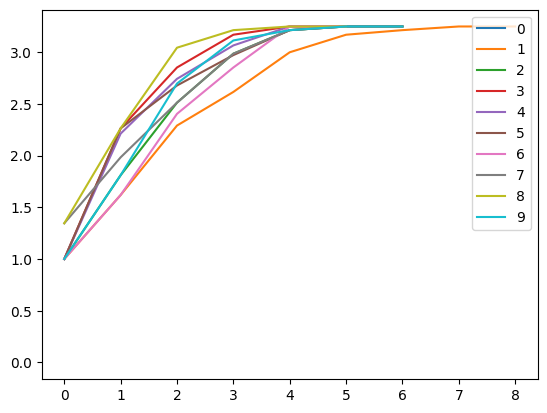

In [ ]:
max = 10
threshold=0.00001
for k in range(max):
  norms = np.zeros(max)
  v, norm = generalized_policy_iteration_v(env.unwrapped, k, threshold, render=False)
  # print(k, ":", norm)
  plt.plot(range(len(norm)), norm, label=k)
  plt.legend(loc='upper right')
plt.show()

Once you have completed the code, perform a study over the values of K and conclude. Among other things, you may try different mazes with different sizes.

#### To recap what we did:

- we tested K values from 0 to 9 on maze environments
- then measured convergence speed and number of iterations
- and compared against standard policy iteration (K = -1)

#### Observations from results:

- K = 0 (no evaluation): Fails to converge or converges very slowly

- K = 1: Fast initial progress but may oscillate or get stuck in suboptimal policies

- K = 2-3: Good balance between speed and stability

- K = 4-6: More stable convergence but slower per iteration

- K ≥ 7: Approaches standard policy iteration performance with diminishing returns

#### Maze Size Impact:

- Small mazes: K = 2-3 often optimal

- Medium mazes: K = 3-4 provides best trade-off

- Large mazes: K = 4-6 recommended for stability

#### Conclusion

Optimal K Range: K = 2-4 provides the best efficiency trade-off for most maze sizes. So too Small K (0-1) gives insufficient policy evaluation leads to oscillation, and too Large K (>6) leads to diminishing returns which means approach is policy iteration cost. So basically, K should scale with problem complexity but rarely needs to exceed 5-6 steps, beyond this point additional evaluation steps become computationally wasteful without improving convergence speed.